In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM

import random

Using TensorFlow backend.


In [2]:


def trainingData():
    """
    Reading Train Data 
    input:
        none
    output:
        data: training dataframe with index => DisplayTime value => GlucoseValues
    """
    
    data = pd.read_csv("~/Desktop/NCSA_genomics/Data/onePersonData.txt", sep="\t")
    #data.head()
    
    #run only once
    #dropping columns we don't need
    data.drop(['subjectId', 'Internal Time'], axis=1, inplace=True)
    #df = data['GlucoseValue']
    #df.index = data['Display Time']
    
    #Converting the Display Time to 'datetime' so that it can be used as an index
    data['Display Time'] = data['Display Time'].apply(lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    data = data.set_index(['Display Time'], drop=True)
    #data.head()
    
    return data

def testingData():
    """
    Reading Test Data 
    input:
        none
    output:
        data: testing dataframe with index => DisplayTime value => GlucoseValues
    """
    
    data = pd.read_csv("~/Desktop/NCSA_genomics/Data/secondPerson.txt", sep="\t")
    #data.head()
    
    #run only once
    #dropping columns we don't need
    data.drop(['subjectId', 'Internal Time'], axis=1, inplace=True)
    #df = data['GlucoseValue']
    #df.index = data['Display Time']
    
    #Converting the Display Time to 'datetime' so that it can be used as an index
    data['Display Time'] = data['Display Time'].apply(lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    data = data.set_index(['Display Time'], drop=True)
    #data.head()
    
    return data

def trainModel(train):
    """
    Training LSTM model
    input:
        train: training dataframe
    output:
        lstm_model: trainied lstm model
    """
    
    #scaling => translates each feature individually such that it is in the given range on the training set
    #to ensure the unit if our data is not a factor

    scaler = MinMaxScaler(feature_range=(0, 1))
    train_sc = scaler.fit_transform(train)

    #Reshaping the data to work for an LSTM network

    train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)


    for s in range(1,2):
        train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)

    X_train = train_sc_df.dropna().drop('Y', axis=1)
    y_train = train_sc_df.dropna().drop('X_1', axis=1)


    X_train = X_train.as_matrix()
    y_train = y_train.as_matrix()


    X_train_lmse = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
   

    print('Train shape: ', X_train_lmse.shape)
    

    lstm_model = Sequential()
    lstm_model.add(LSTM(7, input_shape=(1, X_train_lmse.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
    lstm_model.add(Dense(1))
    lstm_model.compile(loss='mean_squared_error', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
    history_lstm_model = lstm_model.fit(X_train_lmse, y_train, epochs=50, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

    return lstm_model

def testModel(lstm_model,test):
    """
    Testing the LSTM model
    input:
        test: testing dataframe
        lstm_model: trainied lstm model
    output:
        lstm_pred: inverse scaled dataframe of predicted values
        test_val: inverse scaled dataframe of original values
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    test_sc = scaler.fit_transform(test)
    X_test = test_sc[:-1]
    y_test = test_sc[1:]
    test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)
    for s in range(1,2):
        test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)


    X_test = test_sc_df.dropna().drop('Y', axis=1)
    y_test = test_sc_df.dropna().drop('X_1', axis=1)

    X_test = X_test.as_matrix()
    y_test = y_test.as_matrix()
    
    X_test_lmse = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    y_pred_test_lstm = lstm_model.predict(X_test_lmse)
    
    print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
    lstm_test_mse = lstm_model.evaluate(X_test_lmse, y_test, batch_size=1)
   
    print('LSTM: %f'%lstm_test_mse)
    
    #inversing the scaling
    lstm_pred = scaler.inverse_transform(y_pred_test_lstm)
    test_val = scaler.inverse_transform(y_test)
    
    return lstm_pred, test_val


def plot(lstm_pred, test_val):
    #plotting true values and lstm predicted values
    #these are original values

    plt.figure(figsize=(20, 8))
    plt.plot(test_val, label='True')
    plt.plot(lstm_pred, label='LSTM')
    plt.title("LSTM's Prediction")
    plt.xlabel('Observation')
    plt.ylabel('Glucose Values')
    plt.legend()
    plt.show();
    
    
def getMetrics(lstm_pred, test_val):
    #IOA
    ioa_val = index_agreement(lstm_pred,test_val)
    print("Index of Agreement is: " + str(ioa_val))

    #MAE
    mae_val = mae(lstm_pred,test_val)
    print("Mean Absolute Error is: " + str(mae_val))

    #RMSE
    rmse_val = rmse(lstm_pred,test_val)
    print("Root Mean Squared Error is: " + str(rmse_val))
    
    
def index_agreement(s,o):
    """
    index of agreement
    input:
        s: prediceted
        o: original
    output:
        ia: index of agreement
    """
    
    ia = 1 -(np.sum((o-s)**2))/(np.sum((np.abs(s-np.mean(o))+np.abs(o-np.mean(o)))**2))
    
    return ia

def rmse(s,o):
    """
    Root Mean Squared Error
    input:
        s: prediceted
        o: original
    output:
        rmses: root mean squared error
    """
    return np.sqrt(np.mean((s-o)**2))

def mae(s,o):
    """
    Mean Absolute Error
    input:
        s: prediceted
        o: original
    output:
        maes: mean absolute error
    """
    return np.mean(abs(s-o))



def createGap(data):
    """
    Creating Gap indexes
    input:
        data: dataframe with index => DisplayTime value => GlucoseValues
    output:
        start: seed
        end: seed+gap (gap=100)
    """
    
    seed = random.randint(100,len(data)-100)
    
    return seed,seed+200


def faultyData(df,start,end):
    """
    Creating a Gap
    input:
        start: seed
        end: seed+gap (gap=100)
    output:
        df: dataframe with index => DisplayTime value => GlucoseValues and a gap from start to end (inputs)
    """
    
    #df = readData()
    for i in range(start,end):
        df['GlucoseValue'][i]=0
    
    return df



In [3]:
train_set = trainingData()
#print("Training Set:\n")
#viewData(train_set)

test_set = testingData()
#print("Testing Set:\n")
#viewData(test_set)

In [4]:
lstmModel = trainModel(train_set)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Train shape:  (1845, 1, 1)
Epoch 1/50
1845/1845 [==============================] - 4s 2ms/step - loss: 0.0182
Epoch 2/50
1845/1845 [==============================] - 4s 2ms/step - loss: 0.0060
Epoch 3/50
1845/1845 [==============================] - 4s 2ms/step - loss: 9.8107e-04
Epoch 4/50
1845/1845 [==============================] - 4s 2ms/step - loss: 7.6072e-04
Epoch 5/50
1845/1845 [==============================] - 4s 2ms/step - loss: 7.6953e-04
Epoch 6/50
1845/1845 [==============================] - 4s 2ms/step - loss: 7.6503e-04
Epoch 00006: early stopping


In [5]:
predicted, true = testModel(lstmModel,test_set)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


The R2 score on the Test set is:	0.927
1795/1795 [==============================] - 1s 816us/step
LSTM: 0.002062


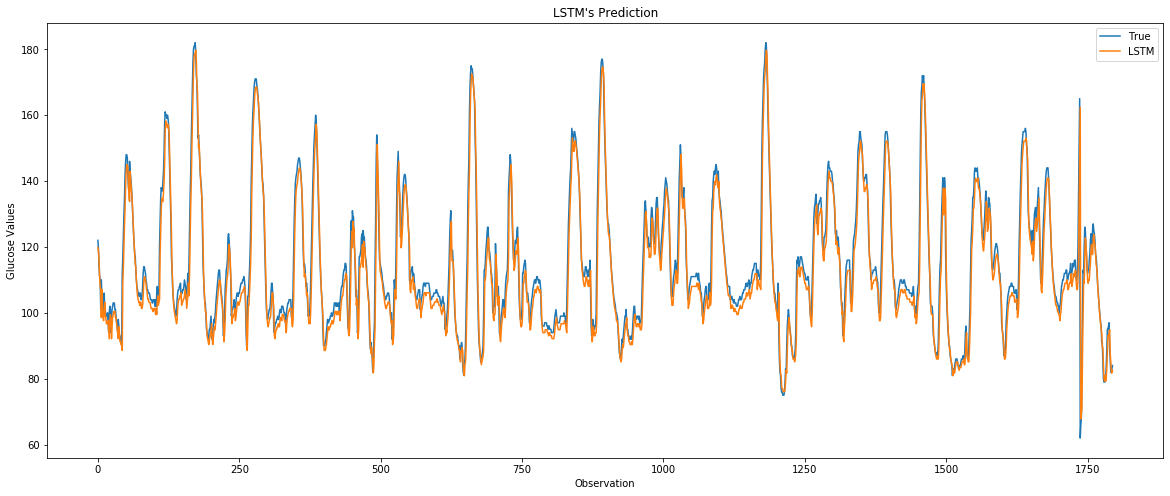

In [6]:
plot(predicted, true)

In [7]:
getMetrics(predicted, true)

Index of Agreement is: 0.981208043119641
Mean Absolute Error is: 3.7514953783295613
Root Mean Squared Error is: 5.448544494747939


In [8]:
#Introducing a gap in the test set
test_set_2 = testingData()
start, end = createGap(test_set_2)
test_set_2 = faultyData(test_set_2,start,end)
print(test_set_2['GlucoseValue'][start])
print(test_set_2['GlucoseValue'][start+10])
print(test_set_2['GlucoseValue'][start+25])

0
0
0


In [9]:
print(start,end)
gap_tester = train_set.iloc[start:end]
#print(gap_tester)

821 1021


In [10]:
predicted2, true2 = testModel(lstmModel,gap_tester)

The R2 score on the Test set is:	0.910
199/199 [==============================] - 0s 834us/step
LSTM: 0.003169


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


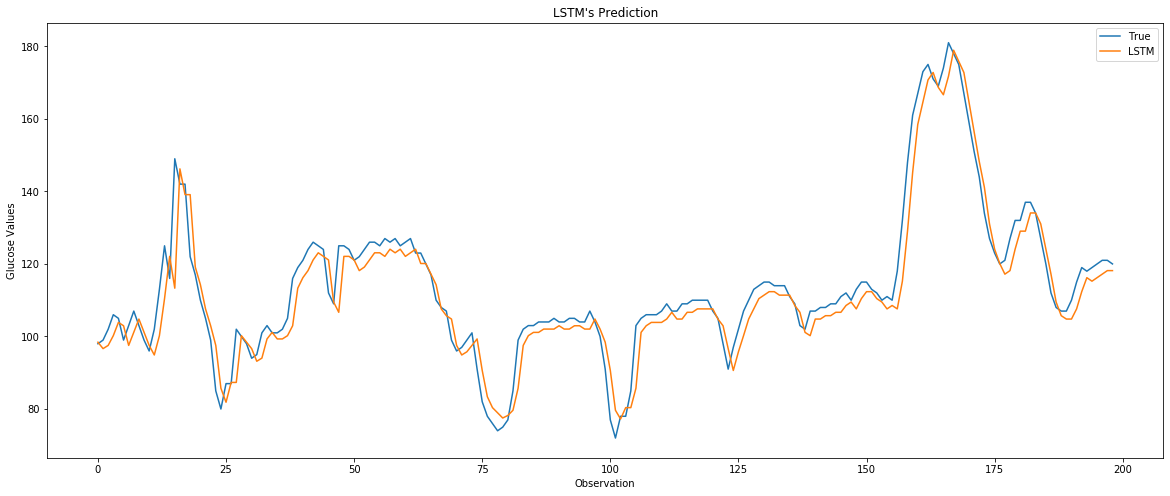

In [11]:
plot(predicted2, true2)

In [12]:
k=0
for i in range(start,end-1):
    test_set_2['GlucoseValue'][i] = predicted2[k][0]
    k=k+1

In [13]:
test_set_2['GlucoseValue'][end-1] = (test_set_2['GlucoseValue'][end-2]+test_set_2['GlucoseValue'][end])/2

In [14]:
#introducing a second gap
start2, end2 = createGap(test_set_2)
test_set_2 = faultyData(test_set_2,start2,end2)
print(test_set_2['GlucoseValue'][start2])
print(test_set_2['GlucoseValue'][start2+10])
print(test_set_2['GlucoseValue'][start2+25])

0
0
0


In [15]:
print(start2,end2)
gap_tester = train_set.iloc[start2:end2]
#print(gap_tester)

1129 1329


In [16]:
predicted3, true3 = testModel(lstmModel,gap_tester)

The R2 score on the Test set is:	0.970
199/199 [==============================] - 0s 834us/step
LSTM: 0.002224


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


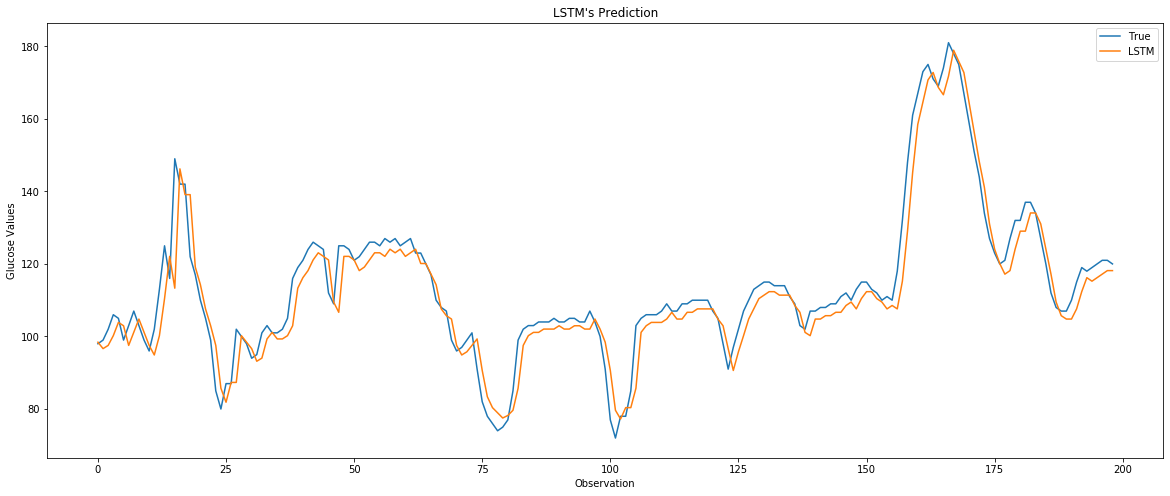

In [17]:
plot(predicted2, true2)

In [18]:
k=0
for i in range(start2,end2-1):
    test_set_2['GlucoseValue'][i] = predicted2[k][0]
    k=k+1

In [19]:
test_set_2['GlucoseValue'][end2-1] = (test_set_2['GlucoseValue'][end2-2]+test_set_2['GlucoseValue'][end2])/2

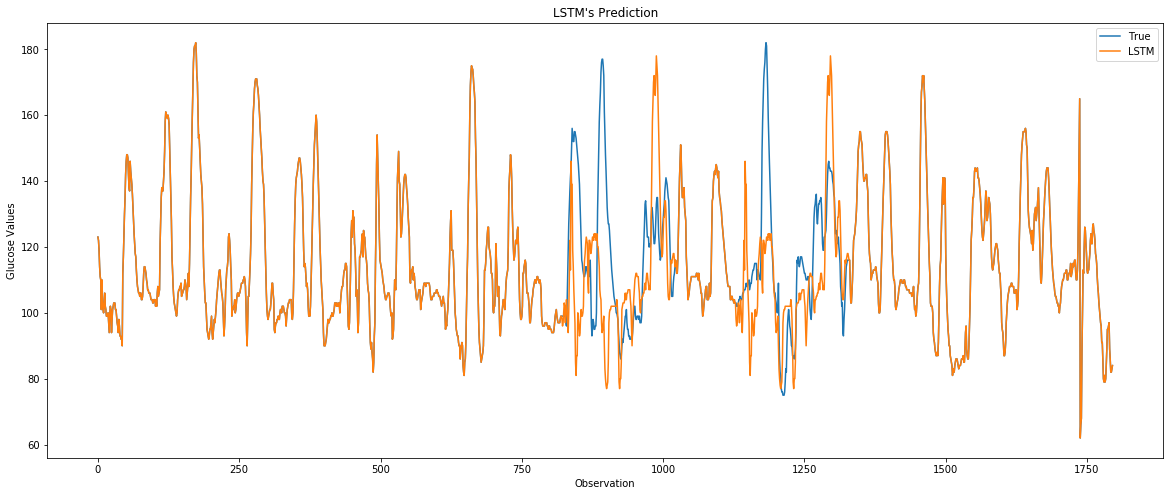

In [20]:
plot(test_set_2['GlucoseValue'].tolist(),test_set['GlucoseValue'].tolist())

In [21]:
getMetrics(test_set_2['GlucoseValue'],test_set['GlucoseValue'])

Index of Agreement is: 0.912908240595533
Mean Absolute Error is: 3.8975501113585747
Root Mean Squared Error is: 11.534059179583274
